In [191]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit import transpile


import matplotlib.pyplot as plt

import numpy as np

# Overview 

Let $n\in \mathbb{N}$ and let $U\in \mathcal{U}(2)$. We define the {\em multi-controlled $U$ gate} on a computational basis vector $\ket{x}_n\ket{y}\in \mathbb{C}^{2^n}\otimes \mathbb{C}^2$ by
$$
    (C^nU)\ket{x}_n\ket{y}
    =
    \begin{cases}
    \ket{x}_n U\ket{y} \quad \text{ if }x_i=1 \,\forall i\in [n]\\
    \ket{x}_n \ket{y} \quad \text{ else } 
    \end{cases}.
$$

Prompt: Define a function which implements $C^nU$ using only single-qubit gates and CX. 

Sources: Our sources for algorithms are 
1. *Quantum Information and Quantum Computation*, Nielsen and Chuang.
2. *Elementary gates for quantum computation*, Barenco-Bennett-Cleve-DiVicenzo-Margolus-Shor-Sleator-Smolin-Weinfurter (1995).

Methods: We have attempted a couple implementations of mcu(n,U), including:

A. **Figure 4.10 (NC)**. Main challenge: Requires iterated CCX (Toffoli) gates whose
controls and target qubits move according to a for loop.

B. **Generalized Figure 4.6 (NC)** with the CX gates replaced by MCX gates, which is described
in Lemma 7.9 (BBCDMSSSW). Main challenge: Requires a decomposition of MCX gates into single-qubit and CNOT gates. We got as far as implementing 4.6 on a 3-qubit register, but not for arbitrary $n$, as the $n=3$ case requires a decomposition of ccx gates, which we completed for Method A, but $n\geq 4$ requires a decompsoition for general mcx.

# Input
1. First we'll give the user a space to input their unitary $U = R_z(\phi)R_y(\theta)R_z(\lambda)$ by entering $\phi$, $\theta$, and $\lambda$ as parameters.
2. With $U$ fixed by choosing parameters, user can input $n$ into the function mcu(n), which will involve one or more sub-functions, either mcx(n) or iterations of ccx(c1,c2,tbit), depending on the method of implementation. For us, we only successfully implemented the latter in Method A.

# Method A for implementing MCU

1. (4.1 & 4.2, Nielsen-Chuang) Up to a global phase, any unitary $U$ can be decomposed as $AXBXC$ where $A,B,C\in \mathcal{U}(2)$ are single-qubit gates which satisfy $ABC=I$ and can be explicitly defined in terms of the initial inputs $\phi$, $\theta$, $\lambda$:
$$
    A = R_z(\phi)R_y(\theta/2)\\
    B = R_y(-\theta/2)R_z(-(\phi + \lambda)/2)\\
    C = R_z(-(\phi-\lambda)/2).
$$

2. (4.6, Nielsen-Chuang) The single-qubit controlled $U$-gate CU decomposes as $(I\otimes A)\circ CX \circ (I\otimes B) \circ CX \circ (I\otimes B)$, where $I$ represents the identity on 1 qubit. 

**CU via Figure 4.6 (NC)**

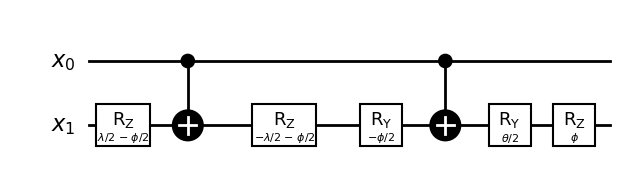

In [236]:

n = 2
cbits = range(0,n-1)

#Parameters which define U

al = Parameter(r"$\alpha$")
theta = Parameter(r"$\theta$")
phi = Parameter(r"$\phi$")
lam = Parameter(r"$\lambda$")


quantum_register = QuantumRegister(n,'x')
cbits = list(range(0,n-1))

Controlled_U_Circuit = QuantumCircuit(quantum_register)

#Controlled_U_Circuit.mcp(al,cbits,n-1) #This would implement the e^(i\alpha) part of U
Controlled_U_Circuit.rz(-(phi-lam)/2,n-1) #Here is C
Controlled_U_Circuit.mcx(cbits,n-1)
Controlled_U_Circuit.rz(-(phi+lam)/2,n-1) #Here is B, part 1
Controlled_U_Circuit.ry(-phi/2,n-1) #Here is B, part 2
Controlled_U_Circuit.mcx(cbits,n-1)
Controlled_U_Circuit.ry(theta/2,n-1) #Here is A, part 1
Controlled_U_Circuit.rz(phi,n-1) #Here is A, part 2

Controlled_U_Circuit.draw(output="mpl", style="bw")


**Nielsen-Chuang Figure 4.10**

The picture above comes up in both Methods A and B. For Method A, we want to implement Figure 4.10 (NC), which includes $n+2$ ccx gates and a CU gate, as above. Although Method A is currently our only effective implementation, it is not very efficient given the number of ccx gates required, each of which has a time complexity of 10 (based on our coding of it). Below we give a decomposition of ccx using the transpile function and then code it in the subsequent block.

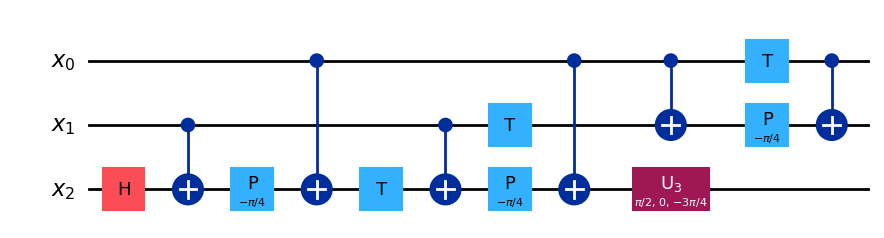

In [219]:
#Decomposition of ccx

qr = QuantumRegister(3,'x')
qc = QuantumCircuit(qr)

qc.ccx(0,1,2)
decomposed_ccx = transpile(qc, basis_gates=['ry','p','t','s','h','u3','cx'])
decomposed_ccx.draw(output="mpl")

In [240]:
n = 5 #Make sure this n matches the n in the previous code box for 
#the decomposition of the Toffoli (ccx) gate.
tbit = n-1 #last qubit in main register
cbit = -1 #last ancilla qubit

#Parameters defining U
#al = Parameter(r"$\alpha$")
theta = Parameter(r"$\theta$")
phi = Parameter(r"$\phi$")
lam = Parameter(r"$\lambda$")

qr = QuantumRegister(n,'x')
ar = AncillaRegister(n-2,'a')

#defining controlled U
control_u_circuit = QuantumCircuit(qr,ar,name = 'Controlled U')
control_u_circuit.u(theta,phi,lam,tbit)
control_u = control_u_circuit.to_gate(tbit).control(1)
control_u_circuit.qubits = [cbit,tbit]



mcu_qc = QuantumCircuit(qr,ar,name = 'Multi-controlled U')

#The first Toffoli gate in Figure 4.10 always has the 0,1 qubits as controls
#and the first ancilla bit (-(n-2)) as the target.

mcu_qc.ccx(0,1,-(n-2)) 
    

#Now we'll apply the iterated Toffoli gates before the controlled U gate.

for i in range(2,n-1):
    mcu_qc.ccx(i,i+(n-2),i+n-1) 

mcu_qc.barrier()

#

#Here we apply U to the last qubit, whose decomposition we will show in a later step.

mcu_qc.append(control_u, control_u_circuit.qubits)
#

mcu_qc.barrier()

#Now we'll apply the rest of the iterated Toffoli gates following the controlled U gate.

for i in reversed(range(2,n-1)):
    mcu_qc.ccx(i,i+(n-2),i+n-1) 

#The last Toffoli gate in Figure 4.10 always has the 0,1 qubits as controls
#and the first ancilla bit (-(n-2)) as the target.

mcu_qc.ccx(0,1,-(n-2)) 

mcu_qc.draw(output="mpl")

AttributeError: 'int' object has no attribute 'items'

# CCX (Toffoli) decomposition

Here we give a decomposition of CCX inside a register of size $2n-2$ (to allow for an $n-2$-bit ancilla register) where the control bits, c1 and c2, and the target bit, tbit, can be chosen.

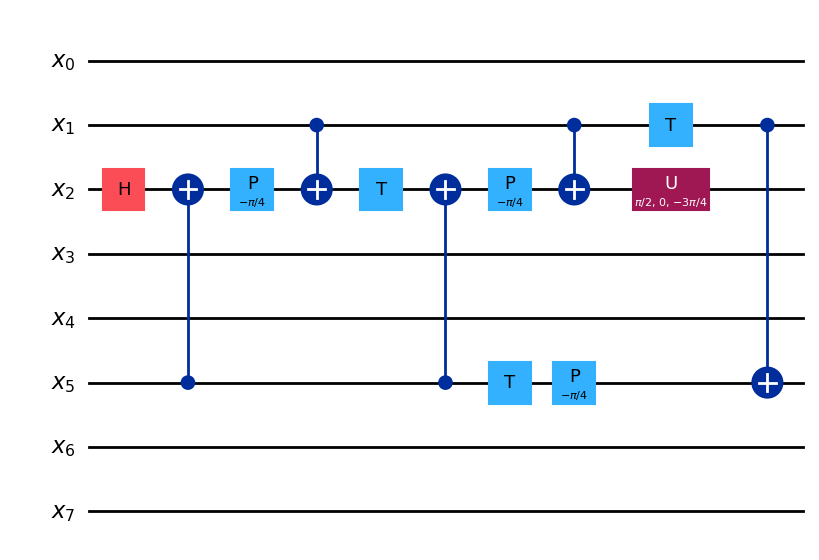

In [ ]:
## Here is a decomposition of the Toffoli gate 
# on a 2n-2 qubit register (size needed for next step)

n = 5 #number of bits in quantum register (not including ancilla)
#2n-2 is how many total bits will be in combined register for 
#implementing mcu

c1 = 1 #one of the two control bits
c2 = 5 #one of the two control bits
tbit = 2 #target bit


qr = QuantumRegister(2*n-2,'x')#
qc_ccx = QuantumCircuit(qr)

#This is just copied from transpile of ccx above

def ccx(c1,c2,tbit):
    qc_ccx.h(tbit)
    qc_ccx.cx(c2,tbit)
    qc_ccx.p(-np.pi/4,tbit)
    qc_ccx.cx(c1,tbit)
    qc_ccx.t(tbit)
    qc_ccx.cx(c2,tbit)
    qc_ccx.t(c2)
    qc_ccx.p(-np.pi/4,tbit)
    qc_ccx.cx(c1,tbit)
    qc_ccx.u(np.pi/2,0,-3*np.pi/4,tbit)
    qc_ccx.t(c1)
    qc_ccx.p(-np.pi/4,c2)
    qc_ccx.cx(c1,c2)
    return qc_ccx

#qc_ccx.compose(ccx(c1,c2,tbit),inplace = True)
ccx(c1,c2,tbit)

qc_ccx.draw(output="mpl")



Note that this decomposition of the Toffoli gate has a time complexity of 10, while a common decomposition of the same gate using only the H, T, Tdag, S, and CX gates as in Figure 4.9 (NC) has a time complexity of 13. 

We will now use our decomposition of ccx above to implement Method B with only single-qubit and CNOT gates.

In [226]:
n = 5 #Make sure this n matches the n in the previous code box for 
#the decomposition of the Toffoli (ccx) gate.

al = Parameter(r"$\alpha$")
theta = Parameter(r"$\theta$")
phi = Parameter(r"$\phi$")
lam = Parameter(r"$\lambda$")


qr = QuantumRegister(n,'x')
ar = AncillaRegister(n-2,'a')

mcu_qc = QuantumCircuit(qr,ar,name = 'Multi-controlled X')

#The first Toffoli gate in Figure 4.10 always has the 0,1 qubits as controls
#and the first ancilla bit (-(n-2)) as the target.

    ##Pick one of the following two to uncomment:
mcu_qc.compose(ccx(0,1,-(n-2)),inplace = True) #Uncomment to decompose ccx
#mcu_qc.ccx(0,1,-(n-2)) #Uncomment to compress ccx
    ##

#Now we'll apply the iterated Toffoli gates before the controlled U gate.

for i in range(2,n-1):
        ##Pick one of the following two to uncomment:
    mcu_qc.compose(ccx(i,i+(n-2),i+(n-1)),inplace = True) #Uncomment to decompose ccx
    #mcu_qc.ccx(i,i+(n-2),i+n-1) #Uncomment to compress ccx
        ##

mcu_qc.barrier()

#Here we have U decomposed using Figure 4.6 (code written earlier).

#Begin controlled U gate #
mcu_qc.rz(-(phi-lam)/2,n-1)
mcu_qc.cx(-1,n-1)
mcu_qc.rz(-(phi+lam)/2,n-1)
mcu_qc.ry(-phi/2,n-1)
mcu_qc.cx(-1,n-1)
mcu_qc.ry(theta/2,n-1)
mcu_qc.rz(phi,n-1)
# End controlled U gate#

mcu_qc.barrier()

#Now we'll apply the rest of the iterated Toffoli gates following the controlled U gate.

for i in reversed(range(2,n-1)):
        ##Pick one of the following two to uncomment:
    mcu_qc.compose(ccx(i,i+(n-2),i+(n-1)),inplace = True) #Uncommenting decomposes ccx
    #mcu_qc.ccx(i,i+(n-2),i+n-1) #Uncommenting compresses ccx
        ##

#The last Toffoli gate in Figure 4.10 always has the 0,1 qubits as controls
#and the first ancilla bit (-(n-2)) as the target.

    ##Pick one of the following two to uncomment:
mcu_qc.compose(ccx(0,1,-(n-2)),inplace = True) #Uncommenting this decomposes ccx
#mcu_qc.ccx(0,1,-(n-2)) #Uncommenting this compresses ccx
    ##

#mcu_qc.draw(output="mpl")

# Complexity

Our implementation of mcx on an $n$-qubit register has a fixed time complexity of 11 involving cx, t, h, and p($\pi/4$), regardless of $n$. Our implementation of $A$, $B$, and $C$ in the decomposition for $U$ requires 5 gates involving rz and ry, only. The total time complexity, then for implementing our $mcu(n,U)$ is 27, given that we apply the mcx gate twice in a single iteration of our mcu circuit.









Below here is stuff we probably won't use.

# Method B: Generalization of Figure 4.6 using MCX





In [64]:
#Let's try to define a function which will implement this.

n = 3
quantum_register = QuantumRegister(n,'x')
quantum_circuit = QuantumCircuit(quantum_register, name='decompose mcx')

def mcx(n):
    quantum_circuit.p(np.pi/8,cbits)
    quantum_circuit.u(np.pi/2,np.pi/8,-np.pi,n-1)
    for j in range(1,n):
        for i in range(2**j):
            quantum_circuit.cx(i,j)
            quantum_circuit.p(-np.pi/8,j)
            #if i % 2**(j-1)==1:
             #   quantum_circuit.cx(j-i-1,j)     
            #else:
            #    i=i+1 #next i!
             #   quantum_circuit.p(np.pi/8,j)
            quantum_circuit.barrier()
    quantum_circuit.h(n-1) 
    return quantum_circuit   
               


quantum_circuit.compose(mcx(n),inplace = True)
quantum_circuit.draw(output="mpl")


CircuitError: 'duplicate qubit arguments'

In [ ]:
n = 3
cbits = list(range(0,n-1))

quantum_register = QuantumRegister(n,'x')
quantum_circuit  = QuantumCircuit(quantum_register, name = 'base')

quantum_circuit.cp(al,cbits,n-1)
quantum_circuit.compose(app_C, inplace=True)
quantum_circuit.mcx(cbits,n-1)
quantum_circuit.compose(app_B, inplace=True)
quantum_circuit.mcx(cbits,n-1)
quantum_circuit.compose(app_A, inplace=True)

quantum_circuit.draw(output="mpl")



NameError: name 'app_C' is not defined

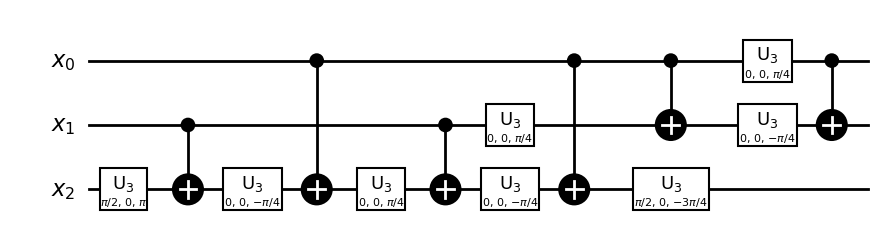

In [ ]:
decomposed_qc = transpile(qc, basis_gates=['u3', 'cx'])

decomposed_qc.draw(output="mpl", style="bw")